## Run on google-colab

Problem Statement : Detect name of bacteria causing disease in Tomato & Potato Plant, 
                    Dataset is limited to these disease only
  
                    Tomato__Tomato_mosaic_virus
                    Potato___Late_blight
                    Tomato_healthy
                    Pepper__bell___healthy
                    Tomato_Early_blight
                    Tomato__Tomato_YellowLeaf__Curl_Virus
                    Tomato_Spider_mites_Two_spotted_spider_mite
                    Tomato_Bacterial_spot
                    Tomato_Late_blight
                    Potato___Early_blight
                    Pepper__bell___Bacterial_spot
                    Tomato_Leaf_Mold
                    Tomato__Target_Spot
                    Potato___healthy
                    Tomato_Septoria_leaf_spot

Dataset Link : https://www.kaggle.com/datasets/emmarex/plantdisease

Solution Approach : 
We're using Transfer Learning EfficientNet-B5 as it's the state-of-the art model for Image Classifiaction problem



In [ ]:
#!lscpu
!free -h --si | awk  '/Mem:/{print $2}'
!nvidia-smi

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download emmarex/plantdisease

In [3]:
from zipfile import ZipFile

path='/content/plantdisease.zip'
zip_ptr = ZipFile(path)
zip_ptr.extractall()
zip_ptr.close()

In [4]:
import cv2
import time
import scipy as sp
import numpy as np
import random as rn
import pandas as pd
from tqdm import tqdm
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.activations import elu
from keras.optimizers import Adam
from keras.models import Sequential
#from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.layers import GroupNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score

Input Image Dimensions for different EfficientNet Models:

    EfficientNetB0 - (224, 224, 3)
    EfficientNetB1 - (240, 240, 3)
    EfficientNetB2 - (260, 260, 3)
    EfficientNetB3 - (300, 300, 3)
    EfficientNetB4 - (380, 380, 3)
    EfficientNetB5 - (456, 456, 3)
    EfficientNetB6 - (528, 528, 3)
    EfficientNetB7 - (600, 600, 3)


In [5]:
IMG_WIDTH = 456
IMG_HEIGHT = 456
CHANNELS = 3

In [6]:
root_dir='/content/PlantVillage'

In [7]:
import glob
## each folder contain images of one category
labels = []
for path in glob.glob(f"{root_dir}/*"):
  label = path.split('/')
  print(label[-1])
  labels.append(label[-1])


Potato___Early_blight
Tomato_healthy
Potato___Late_blight
Pepper__bell___Bacterial_spot
Tomato_Septoria_leaf_spot
Tomato_Late_blight
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato__Target_Spot
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato_Leaf_Mold
Tomato__Tomato_mosaic_virus
Tomato_Bacterial_spot
Potato___healthy
Pepper__bell___healthy
Tomato_Early_blight


In [8]:
# from keras.utils.image_utils import img_to_array

# def convert_image_to_array(image_dir):
#     try:
#         image = cv2.imread(image_dir)
#         if image is not None :
#             image = cv2.resize(image, (224, 224))    #default_image_size
#             return img_to_array(image)
#         else :
#             return np.array([])
#     except Exception as e:
#         print(f"Error : {e}")
#         return None

In [9]:
from tqdm import tqdm
import cv2

images=[]
image_labels = []
## each category has different number of images , to create an unbiased classifier we need
## to give equal weights to all the classes , here category with lowest no of images is 151
## so we're taking 150 images from each category

for label in labels:
  image_label = root_dir+"/"+label
  print(f"checking {image_label}")
  i=0
  for path in tqdm(glob.glob(f"{root_dir}/{label}/*")):
    
    if path.endswith(".jpg") or path.endswith(".JPG"):
      i+=1
      if i>150: break
      image = cv2.imread(path)
      if image is not None:
        image = cv2.resize(image,(IMG_WIDTH,IMG_HEIGHT))
        images.append(path)
        image_labels.append(label)


checking /content/PlantVillage/Potato___Early_blight


 15%|█▌        | 150/1000 [00:00<00:01, 504.39it/s]


checking /content/PlantVillage/Tomato_healthy


  9%|▉         | 150/1591 [00:00<00:02, 523.19it/s]


checking /content/PlantVillage/Potato___Late_blight


 15%|█▌        | 150/1000 [00:00<00:01, 542.14it/s]


checking /content/PlantVillage/Pepper__bell___Bacterial_spot


 15%|█▌        | 150/997 [00:00<00:01, 594.22it/s]


checking /content/PlantVillage/Tomato_Septoria_leaf_spot


  8%|▊         | 150/1771 [00:00<00:02, 560.75it/s]


checking /content/PlantVillage/Tomato_Late_blight


  8%|▊         | 150/1909 [00:00<00:02, 656.98it/s]


checking /content/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus


  5%|▍         | 150/3209 [00:00<00:04, 636.73it/s]


checking /content/PlantVillage/Tomato__Target_Spot


 11%|█         | 150/1404 [00:00<00:02, 587.70it/s]


checking /content/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite


  9%|▉         | 150/1676 [00:00<00:02, 566.50it/s]


checking /content/PlantVillage/Tomato_Leaf_Mold


 16%|█▌        | 150/952 [00:00<00:01, 572.50it/s]


checking /content/PlantVillage/Tomato__Tomato_mosaic_virus


 40%|████      | 150/373 [00:00<00:00, 327.35it/s]


checking /content/PlantVillage/Tomato_Bacterial_spot


  7%|▋         | 150/2127 [00:00<00:04, 446.65it/s]


checking /content/PlantVillage/Potato___healthy


 99%|█████████▊| 150/152 [00:00<00:00, 591.78it/s]


checking /content/PlantVillage/Pepper__bell___healthy


 10%|█         | 150/1478 [00:00<00:02, 602.38it/s]


checking /content/PlantVillage/Tomato_Early_blight


 15%|█▌        | 150/1000 [00:00<00:01, 575.52it/s]


In [10]:
from sklearn import preprocessing

df=pd.DataFrame(images,columns=['image'])
df['class']=image_labels
df = df.sample(frac = 1)

label_encoder = preprocessing.LabelEncoder()
df['class_id']= label_encoder.fit_transform(df['class'])
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
df['class_id']=df['class_id'].astype('str')

print(category_mapping)
df.head(5)

{'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


,image,class,class_id
1228,/content/PlantVillage/Tomato_Spider_mites_Two_...,Tomato_Spider_mites_Two_spotted_spider_mite,10
34,/content/PlantVillage/Potato___Early_blight/34...,Potato___Early_blight,2
1634,/content/PlantVillage/Tomato__Tomato_mosaic_vi...,Tomato__Tomato_mosaic_virus,13
238,/content/PlantVillage/Tomato_healthy/45b3e6ad-...,Tomato_healthy,14
1400,/content/PlantVillage/Tomato_Leaf_Mold/e8e4c7f...,Tomato_Leaf_Mold,8


In [11]:
import os,shutil

#category_ids = df.category_id.unique()

TRAIN_IMAGES_PATH='/content/train'
VAL_IMAGES_PATH='/content/val'
os.makedirs(TRAIN_IMAGES_PATH,exist_ok=True)
os.makedirs(VAL_IMAGES_PATH,exist_ok=True)


for class_id in [x for x in range(len(labels))]:
  os.makedirs(os.path.join(TRAIN_IMAGES_PATH, str(class_id)),exist_ok=True)
  os.makedirs(os.path.join(VAL_IMAGES_PATH, str(class_id)),exist_ok=True)


In [12]:
from sklearn.model_selection import train_test_split

def preprocess_data(df,image_path):
  for index,row in tqdm(df.iterrows(),total=len(df)):
    idx = row["class_id"]
    shutil.copy(row["image"],os.path.join(image_path, str(idx)))

df_train, df_valid = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
preprocess_data(df_train, TRAIN_IMAGES_PATH)
preprocess_data(df_valid, VAL_IMAGES_PATH)

100%|██████████| 450/450 [00:00<00:00, 3645.35it/s]


In [13]:
NUMBER_OF_TRAINING_IMAGES = 1800
NUMBER_OF_VALIDATION_IMAGES = 450
BATCH_SIZE = 4
EPOCHS = 50

In [14]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)# Note that the validation data should not be augmented!#and a very important step is to normalise the images through  rescaling
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    TRAIN_IMAGES_PATH,
    # All images will be resized to target height and width.
    target_size=(IMG_WIDTH,IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    # Since we use categorical_crossentropy loss, we need categorical labels
    class_mode="categorical",
)
validation_generator = test_datagen.flow_from_directory(
    VAL_IMAGES_PATH,
    target_size=(IMG_WIDTH,IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)


Found 1800 images belonging to 15 classes.
Found 450 images belonging to 15 classes.


In [15]:
# class GroupNormalization(tf.keras.layers.Layer):
#     """Group normalization layer
#     Group Normalization divides the channels into groups and computes within each group
#     the mean and variance for normalization. GN's computation is independent of batch sizes,
#     and its accuracy is stable in a wide range of batch sizes
#     # Arguments
#         groups: Integer, the number of groups for Group Normalization.
#         axis: Integer, the axis that should be normalized
#             (typically the features axis).
#             For instance, after a `Conv2D` layer with
#             `data_format="channels_first"`,
#             set `axis=1` in `BatchNormalization`.
#         epsilon: Small float added to variance to avoid dividing by zero.
#         center: If True, add offset of `beta` to normalized tensor.
#             If False, `beta` is ignored.
#         scale: If True, multiply by `gamma`.
#             If False, `gamma` is not used.
#             When the next layer is linear (also e.g. `nn.relu`),
#             this can be disabled since the scaling
#             will be done by the next layer.
#         beta_initializer: Initializer for the beta weight.
#         gamma_initializer: Initializer for the gamma weight.
#         beta_regularizer: Optional regularizer for the beta weight.
#         gamma_regularizer: Optional regularizer for the gamma weight.
#         beta_constraint: Optional constraint for the beta weight.
#         gamma_constraint: Optional constraint for the gamma weight.
#     # Input shape
#         Arbitrary. Use the keyword argument `input_shape`
#         (tuple of integers, does not include the samples axis)
#         when using this layer as the first layer in a model.
#     # Output shape
#         Same shape as input.
#     # References
#         - [Group Normalization](https://arxiv.org/abs/1803.08494)
#     """

#     def __init__(self,
#                  groups=32,
#                  axis=-1,
#                  epsilon=1e-5,
#                  center=True,
#                  scale=True,
#                  beta_initializer='zeros',
#                  gamma_initializer='ones',
#                  beta_regularizer=None,
#                  gamma_regularizer=None,
#                  beta_constraint=None,
#                  gamma_constraint=None,
#                  **kwargs):
#         super(GroupNormalization, self).__init__(**kwargs)
#         self.supports_masking = True
#         self.groups = groups
#         self.axis = axis
#         self.epsilon = epsilon
#         self.center = center
#         self.scale = scale
#         self.beta_initializer = initializers.get(beta_initializer)
#         self.gamma_initializer = initializers.get(gamma_initializer)
#         self.beta_regularizer = regularizers.get(beta_regularizer)
#         self.gamma_regularizer = regularizers.get(gamma_regularizer)
#         self.beta_constraint = constraints.get(beta_constraint)
#         self.gamma_constraint = constraints.get(gamma_constraint)

#     def build(self, input_shape):
#         dim = input_shape[self.axis]

#         if dim is None:
#             raise ValueError('Axis ' + str(self.axis) + ' of '
#                              'input tensor should have a defined dimension '
#                              'but the layer received an input with shape ' +
#                              str(input_shape) + '.')

#         if dim < self.groups:
#             raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
#                              'more than the number of channels (' +
#                              str(dim) + ').')

#         if dim % self.groups != 0:
#             raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
#                              'multiple of the number of channels (' +
#                              str(dim) + ').')

#         self.input_spec = tf.keras.layers.InputSpec(ndim=len(input_shape),
#                                     axes={self.axis: dim})
#         shape = (dim,)

#         if self.scale:
#             self.gamma = self.add_weight(shape=shape,
#                                          name='gamma',
#                                          initializer=self.gamma_initializer,
#                                          regularizer=self.gamma_regularizer,
#                                          constraint=self.gamma_constraint)
#         else:
#             self.gamma = None
#         if self.center:
#             self.beta = self.add_weight(shape=shape,
#                                         name='beta',
#                                         initializer=self.beta_initializer,
#                                         regularizer=self.beta_regularizer,
#                                         constraint=self.beta_constraint)
#         else:
#             self.beta = None
#         self.built = True

#     def call(self, inputs, **kwargs):
#         input_shape = K.int_shape(inputs)
#         tensor_input_shape = K.shape(inputs)

#         # Prepare broadcasting shape.
#         reduction_axes = list(range(len(input_shape)))
#         del reduction_axes[self.axis]
#         broadcast_shape = [1] * len(input_shape)
#         broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
#         broadcast_shape.insert(1, self.groups)

#         reshape_group_shape = K.shape(inputs)
#         group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
#         group_axes[self.axis] = input_shape[self.axis] // self.groups
#         group_axes.insert(1, self.groups)

#         # reshape inputs to new group shape
#         group_shape = [group_axes[0], self.groups] + group_axes[2:]
#         group_shape = K.stack(group_shape)
#         inputs = K.reshape(inputs, group_shape)

#         group_reduction_axes = list(range(len(group_axes)))
#         group_reduction_axes = group_reduction_axes[2:]

#         mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
#         variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

#         inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

#         # prepare broadcast shape
#         inputs = K.reshape(inputs, group_shape)
#         outputs = inputs

#         # In this case we must explicitly broadcast all parameters.
#         if self.scale:
#             broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
#             outputs = outputs * broadcast_gamma

#         if self.center:
#             broadcast_beta = K.reshape(self.beta, broadcast_shape)
#             outputs = outputs + broadcast_beta

#         outputs = K.reshape(outputs, tensor_input_shape)

#         return outputs

#     def get_config(self):
#         config = {
#             'groups': self.groups,
#             'axis': self.axis,
#             'epsilon': self.epsilon,
#             'center': self.center,
#             'scale': self.scale,
#             'beta_initializer': initializers.serialize(self.beta_initializer),
#             'gamma_initializer': initializers.serialize(self.gamma_initializer),
#             'beta_regularizer': regularizers.serialize(self.beta_regularizer),
#             'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
#             'beta_constraint': constraints.serialize(self.beta_constraint),
#             'gamma_constraint': constraints.serialize(self.gamma_constraint)
#         }
#         base_config = super(GroupNormalization, self).get_config()
#         return dict(list(base_config.items()) + list(config.items()))

#     def compute_output_shape(self, input_shape):
#         return input_shape


In [16]:
from keras.applications import EfficientNetB5


efficient_net = EfficientNetB5(
    weights="imagenet",
    input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNELS),
    include_top=False,
    pooling='max'
)
#efficient_net.load_weights('/content/efficientnet-b5_imagenet_1000_notop.h5')


# Replace all Batch Normalization layers by Group Normalization layers
# Batch Normalization becomes unstable with small batch sizes (<16) and 
# that is why we use Group Normalization layers instead
for i, layer in enumerate(efficient_net.layers):
    if "batch_normalization" in layer.name:
        efficient_net.layers[i] = GroupNormalization(groups=32,axis=-1,epsilon=0.0001)

efficient_net.trainable = False
for layer in efficient_net.layers[-20:]:
        if not isinstance(layer, GroupNormalization):
            layer.trainable = True


115263384/115263384 [==============================] - 1s 0us/step


In [17]:
def build_model(efficient_net):
    model = Sequential()
    model.add(efficient_net)
    #model.add(GlobalMaxPooling2D(name="gap"))
    model.add(Dense(units = 120, activation='relu',name="dense_1_out"))

    model.add(Dropout(rate=0.2, name="dropout_out"))
    model.add(Dense(units = 120, activation = 'relu',name="dense_2_out"))
    model.add(Dense(units = 15, activation='softmax',name="fc_out"))
    model.summary()
    return model

# Initialize model
model = build_model(efficient_net)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 dense_1_out (Dense)         (None, 120)               245880    
                                                                 
 dropout_out (Dropout)       (None, 120)               0         
                                                                 
 dense_2_out (Dense)         (None, 120)               14520     
                                                                 
 fc_out (Dense)              (None, 15)                1815      
                                                                 
Total params: 28,775,742
Trainable params: 262,215
Non-trainable params: 28,513,527
_________________________________________________________________


In [18]:
from keras.optimizers import RMSprop
model.compile(
    loss="categorical_crossentropy",
    optimizer=RMSprop(learning_rate=2e-5),
    #optimizer=RAdam(lr=0.00005),
    metrics=["accuracy"]
)

In [19]:

# Monitor MSE to avoid overfitting and save best model
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2)
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=2, 
                        verbose=1, 
                        mode='auto', 
                        min_delta=0.0001)

# Begin training
history = model.fit(train_generator,
                    steps_per_epoch=NUMBER_OF_TRAINING_IMAGES//BATCH_SIZE,epochs=EPOCHS,
                    validation_data=validation_generator,
                    validation_steps = NUMBER_OF_VALIDATION_IMAGES//BATCH_SIZE,
                    callbacks=[es, rlr],verbose=1,
                    use_multiprocessing=True,workers=4)


Epoch 1/50
450/450 [==============================] - 138s 253ms/step - loss: 4.7503 - accuracy: 0.0672 - val_loss: 2.7854 - val_accuracy: 0.0893 - lr: 2.0000e-05
Epoch 2/50
450/450 [==============================] - 108s 238ms/step - loss: 2.7957 - accuracy: 0.0817 - val_loss: 2.6314 - val_accuracy: 0.0826 - lr: 2.0000e-05
Epoch 3/50
450/450 [==============================] - 120s 264ms/step - loss: 2.7222 - accuracy: 0.0850 - val_loss: 2.6512 - val_accuracy: 0.0826 - lr: 2.0000e-05
Epoch 4/50
450/450 [==============================] - 112s 247ms/step - loss: 2.7025 - accuracy: 0.0728 - val_loss: 2.6276 - val_accuracy: 0.1004 - lr: 2.0000e-05
Epoch 5/50
450/450 [==============================] - 111s 245ms/step - loss: 2.7036 - accuracy: 0.0883 - val_loss: 2.6421 - val_accuracy: 0.0871 - lr: 2.0000e-05
Epoch 6/50
450/450 [==============================] - ETA: 0s - loss: 2.7073 - accuracy: 0.0767
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
450/450 [====

In [21]:
model.save_weights("EfficientNetB5_weights.hd5")

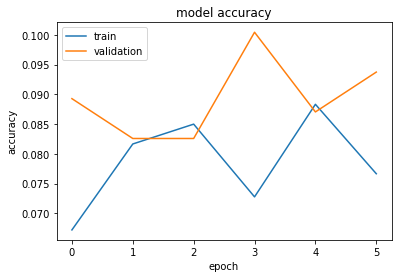

In [25]:
import matplotlib.pyplot as plt


def plot_hist(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

In [26]:
category_mapping

{'Pepper__bell___Bacterial_spot': 0,
 'Pepper__bell___healthy': 1,
 'Potato___Early_blight': 2,
 'Potato___Late_blight': 3,
 'Potato___healthy': 4,
 'Tomato_Bacterial_spot': 5,
 'Tomato_Early_blight': 6,
 'Tomato_Late_blight': 7,
 'Tomato_Leaf_Mold': 8,
 'Tomato_Septoria_leaf_spot': 9,
 'Tomato_Spider_mites_Two_spotted_spider_mite': 10,
 'Tomato__Target_Spot': 11,
 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12,
 'Tomato__Tomato_mosaic_virus': 13,
 'Tomato_healthy': 14}

1/1 [==============================] - 4s 4s/step
Tomato_Leaf_Mold


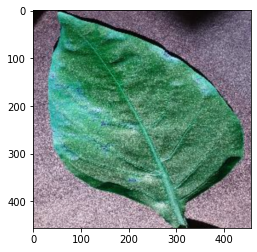

In [27]:
from keras.utils import img_to_array

# test = df.sample(frac=0.2)
# X_test = test.drop(columns=["class","class_id"])
# y_test = test["class_id"]
# for idx,row in tqdm(X_test.iterrows(),total=len(X_test)):
#   img = cv2.imread(row["image"])
#   img = img_to_array(img)
#   X_test.loc[idx]["image"]=img
# # X_test_new = pd.DataFrame(columns=["image"])
# test_datagen = ImageDataGenerator(rescale=1.0 / 255)
# test_generator = test_datagen.flow(
#     X_test,y_test, #flow_from_directory -> don't need it
#     #target_size=(224,224),
#     batch_size=16,
#     # Since we use categorical_crossentropy loss, we need categorical labels
#     #class_mode="categorical",
# )

path='/content/Pepper__bell___Bacterial_spot.jpeg'
img = cv2.imread(path)
img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))

X_test = img_to_array(img).reshape(-1,IMG_WIDTH,IMG_HEIGHT,CHANNELS)
y_test = 0

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred)

for key,val in category_mapping.items():
  if val==y_pred:
    print(key)
    
plt.imshow(img)

1/1 [==============================] - 0s 49ms/step
Potato___Early_blight


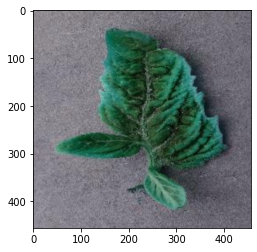

In [28]:
path='/content/Tomato__Tomato_YellowLeaf__Curl_Virus.jpeg'
img = cv2.imread(path)
img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))

X_test = img_to_array(img).reshape(-1,IMG_WIDTH,IMG_HEIGHT,CHANNELS)
y_test = 0

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred)

for key,val in category_mapping.items():
  if val==y_pred:
    print(key)
    
plt.imshow(img)

1/1 [==============================] - 0s 52ms/step
Tomato__Tomato_YellowLeaf__Curl_Virus


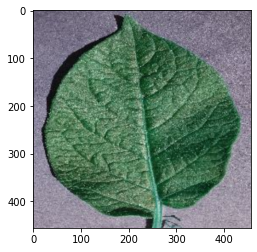

In [29]:
path='/content/Potato___healthy.jpeg'
img = cv2.imread(path)
img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))

X_test = img_to_array(img).reshape(-1,IMG_WIDTH,IMG_HEIGHT,CHANNELS)
y_test = 0

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred)

for key,val in category_mapping.items():
  if val==y_pred:
    print(key)
    
plt.imshow(img)

In [ ]:

#score = model.evaluate(y_test, y_pred,verbose=1)

In [ ]:
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score# Confusion matrix confusion_matrix(y_test, y_pred) 

# precision_score(y_test, y_pred) 

# recall_score(y_test, y_pred) 

# f1_score(y_test,y_pred) 